**Assignment Objective:**

Consider the QWorld environment from your first assignment. The objective of this assignment is to design a agent that learn how to solve this problem through the **sarsamax (Q-learning)** and **sarsa** algorithms seen in class

Provide your answers for **PART1** and **PART2** in this notebook and submit it before the due date.

In [1]:
"""Q Learning to solve a simple world model

Simple deterministic MDP is made of 6 grids (states)
---------------------------------
|         |          |          |
|  Start  |          |  Goal    |
|         |          |          |
---------------------------------
|         |          |          |
|         |          |  Hole    |
|         |          |          |
---------------------------------

"""

from collections import deque
import numpy as np
import argparse
import os
import time
from termcolor import colored


class QWorld:
    def __init__(self):
        """Simulated deterministic world made of 6 states.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = 4

        # 6 states
        self.row = 6

        # setup the environment
        self.init_transition_table()
        self.init_reward_table()

        # reset the environment
        self.reset()

    def reset(self):
        """start of episode"""
        self.state = 0
        self.count = 0
        return self.state

    def is_in_win_state(self):
        """agent wins when the goal is reached"""
        return self.state == 2


    def init_reward_table(self):
        """
        0 - Left, 1 - Down, 2 - Right, 3 - Up
        ----------------
        | 0 | 0 | 100  |
        ----------------
        | 0 | 0 | -100 |
        ----------------
        """
        self.reward_table = np.zeros([self.row, self.col])
        self.reward_table[1, 2] = 100.
        self.reward_table[4, 2] = -100.


    def init_transition_table(self):
        """
        0 - Left, 1 - Down, 2 - Right, 3 - Up
        -------------
        | 0 | 1 | 2 |
        -------------
        | 3 | 4 | 5 |
        -------------
        """
        self.transition_table = np.zeros([self.row, self.col],
                                         dtype=int)

        self.transition_table[0, 0] = 0
        self.transition_table[0, 1] = 3
        self.transition_table[0, 2] = 1
        self.transition_table[0, 3] = 0

        self.transition_table[1, 0] = 0
        self.transition_table[1, 1] = 4
        self.transition_table[1, 2] = 2
        self.transition_table[1, 3] = 1

        # terminal Goal state
        self.transition_table[2, 0] = 2
        self.transition_table[2, 1] = 2
        self.transition_table[2, 2] = 2
        self.transition_table[2, 3] = 2

        self.transition_table[3, 0] = 3
        self.transition_table[3, 1] = 3
        self.transition_table[3, 2] = 4
        self.transition_table[3, 3] = 0

        self.transition_table[4, 0] = 3
        self.transition_table[4, 1] = 4
        self.transition_table[4, 2] = 5
        self.transition_table[4, 3] = 1

        # terminal Hole state
        self.transition_table[5, 0] = 5
        self.transition_table[5, 1] = 5
        self.transition_table[5, 2] = 5
        self.transition_table[5, 3] = 5


    def step(self, action):
        """execute the action on the environment
        Argument:
            action (tensor): An action in Action space
        Returns:
            next_state (tensor): next env state
            reward (float): reward received by the agent
            done (Bool): whether the terminal state
                is reached
        """
        # determine the next_state given state and action
        next_state = self.transition_table[self.state, action]
        # done is True if next_state is Goal or Hole
        done = next_state == 2 or next_state == 5
        # reward given the state and action
        reward = self.reward_table[self.state, action]
        # the enviroment is now in new state
        self.state = next_state
        self.count+=1
        return next_state, reward, done




    def print_cell(self, row=0):
        """UI to display agent moving on the grid"""
        print("")
        for i in range(13):
            j = i - 2
            if j in [0, 4, 8]:
                if j == 8:
                    if self.state == 2 and row == 0:
                        marker = "\033[4mG\033[0m"
                    elif self.state == 5 and row == 1:
                        marker = "\033[4mH\033[0m"
                    else:
                        marker = 'G' if row == 0 else 'H'
                    color = self.state == 2 and row == 0
                    color = color or (self.state == 5 and row == 1)
                    color = 'red' if color else 'blue'
                    print(colored(marker, color), end='')
                elif self.state in [0, 1, 3, 4]:
                    cell = [(0, 0, 0), (1, 0, 4), (3, 1, 0), (4, 1, 4)]
                    marker = '_' if (self.state, row, j) in cell else ' '
                    print(colored(marker, 'red'), end='')
                else:
                    print(' ', end='')
            elif i % 4 == 0:
                    print('|', end='')
            else:
                print(' ', end='')
        print("")


    def print_world(self, action, step,is_explore):
        """UI to display mode and action of agent"""
        actions = { 0: "(Left)", 1: "(Down)", 2: "(Right)", 3: "(Up)" }
        explore = "Explore" if is_explore else "Exploit"
        print("Step", step, ":", explore, actions[action])
        for _ in range(13):
            print('-', end='')
        self.print_cell()
        for _ in range(13):
            print('-', end='')
        self.print_cell(row=1)
        for _ in range(13):
            print('-', end='')
        print("")




In [2]:
def print_episode(episode, delay=1):
    """UI to display episode count
    Arguments:
        episode (int): episode number
        delay (int): sec delay

    """
    os.system('clear')
    for _ in range(13):
        print('=', end='')
    print("")
    print("Episode ", episode)
    for _ in range(13):
        print('=', end='')
    print("")
    time.sleep(delay)


def print_status(q_world,q_agent, done, step, delay=1):
    """UI to display the world,
        delay of 1 sec for ease of understanding
    """
    os.system('clear')
    q_world.print_world(action, step,q_agent.is_explore)
    q_agent.print_q_table()
    if done:
        print("-------EPISODE DONE--------")
        delay *= 2
    time.sleep(delay)

# **PART1**: SARSAMAX agent (off-policy)


## a) complete the TODO parts in the cell below in order to design an agent that learns through Q-learning

In [3]:
class QAgent:
    def __init__(self, col, row, alpha):
        """Q-Learning based agent by Bellman Equation.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = col

        # 6 states
        self.row = row

        # initialize the q table
        self.q_table = np.zeros([self.row, self.col])

        # discount factor
        self.gamma = 0.9

        # learning rate
        self.alpha = alpha

        # 90% exploration, 10% exploitation
        self.epsilon = 0.9
        # exploration decays by this factor every episode
        self.epsilon_decay = 0.9
        # in the long run, 10% exploration, 90% exploitation
        self.epsilon_min = 0

        # set action model to exploration
        self.is_explore = True

    def act(self, state):
        """determine the next action
            either for Q Table(exploitation) or
            random(exploration)
        Return:
            action (tensor): action that the agent
                must execute
        """
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        # action based on exploration

        if np.random.rand() <= self.epsilon:
            #choose a random action
            action = np.random.choice(self.col)
        else:
            #choose the best action with the highest q-value (greedy)
            action = np.argmax(self.q_table[state])

        return action

    def update_q_table(self, state, action, reward, next_state):
        """Q-Learning - update the Q Table using Q(s, a)
        Arguments:
            state (tensor) : agent state
            action (tensor): action executed by the agent
            reward (float): reward after executing action
                for a given state
            next_state (tensor): next state after executing
                action for a given state
        """
        ########################################################
        #TODO update the Q-table with blended Bellman update rule
        ########################################################


        #best action for next state
        best_next_action = np.argmax(self.q_table[next_state])
        #updating bellmann equation
        self.q_table[state, action] += self.alpha * (reward + self.gamma * self.q_table[next_state, best_next_action] - self.q_table[state, action])

    def print_q_table(self):
        """UI to dump Q Table contents"""
        print("Q-Table (Epsilon: %0.2f)" % self.epsilon)
        print(self.q_table)

    def update_epsilon(self):
        """update Exploration-Exploitation mix"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



## b) complete the TODO parts in the cell below order to implement a training loop

Recall the steps seen in class:
1. Start with an empty table for $Q(s, a)$.
2. Obtain $(s, a, r, s')$ from the environment.
3. Make a Bellman update: $𝑄(𝑠, 𝑎) ← (1 − 𝛼)𝑄(𝑠, 𝑎) + 𝛼 (𝑟 + 𝛾\max\limits_{x'\in A} Q(s',a'))$
4. Check convergence conditions. If not met, repeat from step 2.

In [7]:
delay = 0
wins = 0
episode_count = 10000

##################################################
#TODO instantiate an environment q_world
# and an agent called q_agent
##################################################

q_world = QWorld()
q_agent = QAgent(q_world.col, q_world.row, alpha=0.1)

#count the number of iterations
iterations=0

np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    if episode%70==0:
        print_episode(episode, delay=delay)
    while not done:
    ##################################################
    # complete training loop below
    ##################################################
        # todo: choose an action given state
        action = q_agent.act(state)

        # todo: Obtain  next_state, reward, done  from the environment.
        next_state, reward, done = q_world.step(action)


        # todo: update the q-table.
        q_agent.update_q_table(state, action, reward, next_state)


        # todo: update state: the current state becomes the next_state in the next iteration
        state = next_state

        iterations+=1
        # if episode is done:
        if done:
            if q_world.is_in_win_state():
                wins += 1

            percent_wins = 100.0 * wins / (episode + 1)
            if episode % 70 == 0:
                print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))
            # Exploration-Exploitation is updated every episode
            q_agent.update_epsilon()


    if (episode > 100) & (percent_wins >= 99.5):
        print("Solved in episode %d, after %d iterations" % (episode, iterations))
        break

Episode  0
-------0.00% Goals in 0 Episodes---------
Episode  70
-------95.77% Goals in 70 Episodes---------
Episode  140
-------97.87% Goals in 140 Episodes---------
Episode  210
-------98.58% Goals in 210 Episodes---------
Episode  280
-------98.93% Goals in 280 Episodes---------
Episode  350
-------99.15% Goals in 350 Episodes---------
Episode  420
-------99.29% Goals in 420 Episodes---------
Episode  490
-------99.39% Goals in 490 Episodes---------
Episode  560
-------99.47% Goals in 560 Episodes---------
Solved in episode 599, after 1289 iterations


### c) Based on the the cell above, when is the problem considered solved? And, after how many iterations the problem was actually solved?
### **(indicate answer in text cell  here)**

**the problem is considered solved when we reach at least 99.5% success rate. In this example the agent took 599 episodes to reach 99.5% success rate and completed 1289 interations of training.**

### d) Provide a plot of the percent_wins as a function of the iterations (i.e., iteration number on the x-axis and corresponding percent_wins in the y-axis)

Episode  0
-------0.00% Goals in 0 Episodes---------
Episode  70
-------95.77% Goals in 70 Episodes---------
Episode  140
-------97.87% Goals in 140 Episodes---------
Episode  210
-------98.58% Goals in 210 Episodes---------
Episode  280
-------98.93% Goals in 280 Episodes---------
Episode  350
-------99.15% Goals in 350 Episodes---------
Episode  420
-------99.29% Goals in 420 Episodes---------
Episode  490
-------99.39% Goals in 490 Episodes---------
Episode  560
-------99.47% Goals in 560 Episodes---------
Solved in episode 599, after 1289 iterations


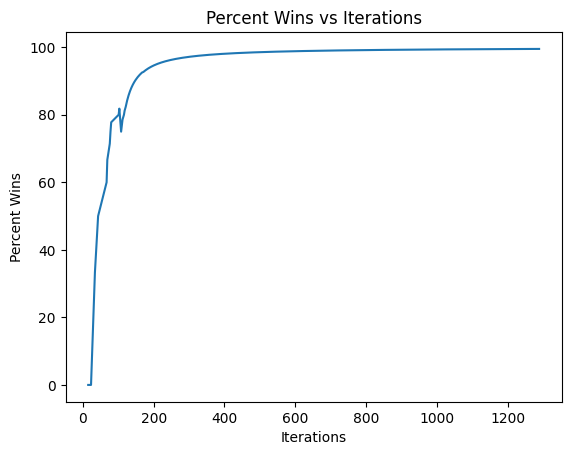

In [13]:
import matplotlib.pyplot as plt

Pwins = []
its = []

delay = 0
wins = 0
episode_count = 10000
q_world = QWorld()
q_agent = QAgent(q_world.col, q_world.row, alpha=0.1)

iterations = 0

np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    #printing small samples
    if episode%70==0:
        print_episode(episode, delay=delay)
    while not done:
        action = q_agent.act(state)
        next_state, reward, done = q_world.step(action)


        q_agent.update_q_table(state, action, reward, next_state)

        state = next_state
        iterations += 1

        if done:
            if q_world.is_in_win_state():
                wins += 1

            percent_wins = 100.0 * wins / (episode + 1)
            if episode % 70 == 0:
                print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))
            Pwins.append(percent_wins)
            its.append(iterations)
            q_agent.update_epsilon()

    if (episode > 100) & (percent_wins >= 99.5):
        print("Solved in episode %d, after %d iterations" % (episode, iterations))
        break

plt.plot(its, Pwins)
plt.xlabel('Iterations')
plt.ylabel('Percent Wins')
plt.title('Percent Wins vs Iterations')
plt.show()

### e) Print the final Q-table (after training loop ends)

In [ ]:
print(q_agent.q_table)

[[  0.600777     0.          90.           0.        ]
 [  0.600777     2.54337213 100.          16.13991943]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.351459     0.        ]
 [  0.           0.351459   -27.1         21.02568763]
 [  0.           0.           0.           0.        ]]


### f) Based on this final table, what is the best action to take if the agent is in state 3?
### **(add answer in text cell here)**

**Action 2 has the highest q value in the row of the 3rd state (0.3514) so it's the best action to take**

### g) Finally, now use your trained agent in 20 episodes-- full exploitation
### Use `print_status` for showing episode results

### Then, provide a plot that shows whether the agent reached the goal or not as a function of the episodes (i.e, x-axis is episode number, y-axis: 1 if goal reached, 0 otherwise)

### Comment on the obtained results.
### What is the percent wins  for these 20 episodes?

In [14]:
num_episodes = 20

goal_reached_list = []

for episode in range(num_episodes):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)
    i=0
    while not done:
        action = q_agent.act(state)
        next_state, reward, done = q_world.step(action)
        state = next_state
        #printing a small sample
        if i%70==0:
            print_status(q_world, q_agent, done, q_world.count, delay)
        i+=1
    goal_reached_list.append(1 if q_world.is_in_win_state() else 0)

percent_wins_exploitation = 100 * sum(goal_reached_list) / num_episodes
print(f"Percent wins in exploitation phase: {percent_wins_exploitation:.2f}%")

Episode  0
Step 1 : Explore (Right)
-------------
|   | _ | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[  0.600777     0.          90.           0.        ]
 [  0.600777     2.54337213 100.          16.13991943]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.351459     0.        ]
 [  0.           0.351459   -27.1         21.02568763]
 [  0.           0.           0.           0.        ]]
Episode  1
Step 1 : Explore (Right)
-------------
|   | _ | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[  0.600777     0.          90.           0.        ]
 [  0.600777     2.54337213 100.          16.13991943]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.351459     0.        ]
 [  0.           0.351459   -27.1         21.02568763]
 [  0.           0.           0.           0.        ]]
Episode  2
Step 1 : Explore (Right)
-------------
|   | _ | G |
-------------


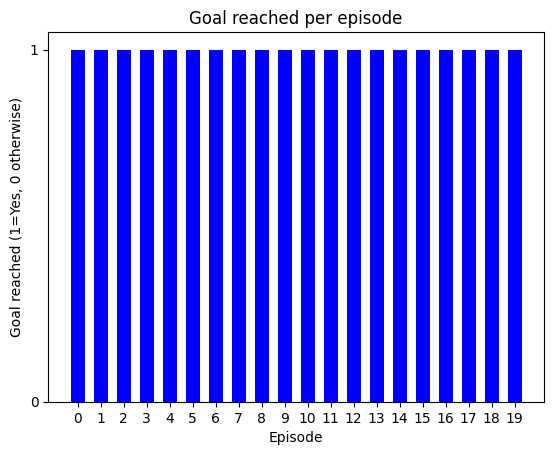

In [15]:
import matplotlib.pyplot as plt
plt.bar(range(num_episodes), goal_reached_list, color='b', width=0.6)
plt.title('Goal reached per episode')
plt.xlabel('Episode')
plt.ylabel('Goal reached (1=Yes, 0 otherwise)')
plt.xticks(range(num_episodes))
plt.yticks([0, 1])
plt.show()


=>during exploitation phase the agent almost always reaches its goal each episode. In this case the success rate is (1-1/20)*100 % = 95%

# **PART2**: SARSA-based agent (ON-policy)
# In this part, you need to implement an agent that learns how to solve this problem with the on-policy sarsa algorithm. Re-answer all the questions as in part A):  from a) to g)

In [16]:
class QAgent:
    def __init__(self, col, row, alpha):
        """SARSA Agent"""
        self.col = col
        self.row = row

        # initialize the q table
        self.q_table = np.zeros([self.row, self.col])

        # discount factor
        self.gamma = 0.9

        # learning rate
        self.alpha = alpha

        # exploration rate
        self.epsilon = 0.9
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.1

    def act(self, state):
        """Choose action based on epsilon-greedy policy"""
        if np.random.rand() <= self.epsilon:
            #exploration
            action = np.random.choice(self.col)
        else:
            #exploitation
            action = np.argmax(self.q_table[state])
        return action

    def update_q_table(self, state, action, reward, next_state, next_action):
        """Update Q-table using SARSA update rule"""
        #SARSA: Q(s,a)=Q(s,a)+alpha*[reward+gamma*Q(s',a')-Q(s,a)]
        self.q_table[state, action] += self.alpha * (
            reward + self.gamma * self.q_table[next_state, next_action] - self.q_table[state, action]
        )

    def update_epsilon(self):
        """Update exploration-exploitation ratio"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def print_q_table(self):
        """Print the Q-table"""
        print(f"Q-Table (Epsilon: {self.epsilon:.2f})")
        print(self.q_table)

# Training

In [17]:
q_world = QWorld()
q_agent = QAgent(q_world.col, q_world.row, alpha=0.1)
delay = 0
wins = 0
episode_count = 10000

iterations = 0
percent_wins_list = []

np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    action = q_agent.act(state)
    if episode%70==0:
        print_episode(episode, delay=delay)

    while not done:
        next_state, reward, done = q_world.step(action)
        next_action = q_agent.act(next_state)

        #updating the q-table using SARSA
        q_agent.update_q_table(state, action, reward, next_state, next_action)

        state = next_state
        action = next_action

        iterations += 1

        if done:
            if q_world.is_in_win_state():
                wins += 1
            percent_wins = 100.0 * wins / (episode + 1)
            percent_wins_list.append(percent_wins)
            if episode%70==0:
                print(f"-------{percent_wins:.2f}% Goals in {episode + 1} Episodes---------")
                q_agent.update_epsilon()

    if (episode > 100) & (percent_wins >= 99.5):
        print("Solved in episode %d, after %d iterations" % (episode, iterations))
        break

Episode  0
-------0.00% Goals in 1 Episodes---------
Episode  70
-------74.65% Goals in 71 Episodes---------
Episode  140
-------82.98% Goals in 141 Episodes---------
Episode  210
-------85.31% Goals in 211 Episodes---------
Episode  280
-------86.48% Goals in 281 Episodes---------
Episode  350
-------88.60% Goals in 351 Episodes---------
Episode  420
-------90.02% Goals in 421 Episodes---------
Episode  490
-------91.24% Goals in 491 Episodes---------
Episode  560
-------92.16% Goals in 561 Episodes---------
Episode  630
-------92.87% Goals in 631 Episodes---------
Episode  700
-------93.44% Goals in 701 Episodes---------
Episode  770
-------94.03% Goals in 771 Episodes---------
Episode  840
-------94.53% Goals in 841 Episodes---------
Episode  910
-------94.95% Goals in 911 Episodes---------
Episode  980
-------95.21% Goals in 981 Episodes---------
Episode  1050
-------95.53% Goals in 1051 Episodes---------
Episode  1120
-------95.81% Goals in 1121 Episodes---------
Episode  1190
---

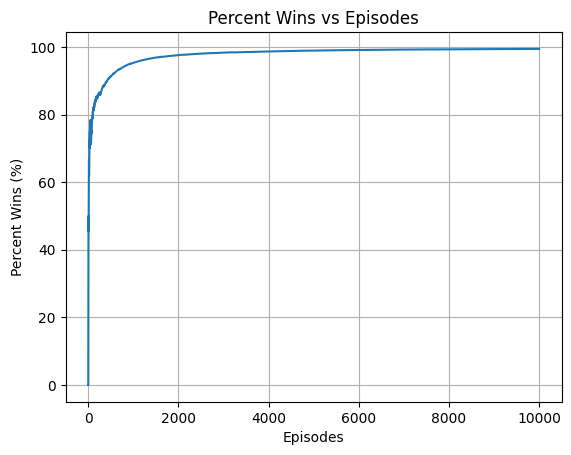

In [18]:
#plotting percent_wins vs episodes
plt.plot(np.arange(1, len(percent_wins_list) + 1), percent_wins_list)
plt.xlabel('Episodes')
plt.ylabel('Percent Wins (%)')
plt.title('Percent Wins vs Episodes')
plt.grid(True)
plt.show()

# Final Q-table

In [19]:
print(q_agent.q_table)

[[ 78.92633952  70.16088915  89.99659222  79.79300701]
 [ 76.4759367   74.74801656 100.          88.64940722]
 [  0.           0.           0.           0.        ]
 [ 56.79119329  49.77430807  68.05851031  78.48814547]
 [ 60.8281146   58.16291572 -99.75349653  87.04681189]
 [  0.           0.           0.           0.        ]]


=> Action 3 is the best action to take in state 3 with the highest q-value (78.48814547)

#  

In [20]:
num_episodes = 20
goal_reached_list = []

#redefining print_status for the sarsa agent
def print_status(q_world, q_agent, done, step, delay, is_exploring):
    os.system('clear')
    q_world.print_world(action, step, is_exploring)
    q_agent.print_q_table()
    if done:
        print(f"Episode finished after {step} steps")


for episode in range(num_episodes):
    state = q_world.reset()
    done = False
    q_agent.update_epsilon()
    #printing a small sparse sample of episodes
    if episode%70==0:
        print_episode(episode, delay=delay)

    action = q_agent.act(state)

    while not done:
        next_state, reward, done = q_world.step(action)
        next_action = q_agent.act(next_state)
        q_agent.update_q_table(state, action, reward, next_state, next_action)
        state = next_state
        action = next_action
        #check if agent is in exploration phase
        is_exploring = q_agent.epsilon > q_agent.epsilon_min
        print_status(q_world, q_agent, done, q_world.count, delay, is_exploring)

    goal_reached_list.append(1 if q_world.is_in_win_state() else 0)

percent_wins_exploitation = 100 * sum(goal_reached_list) / num_episodes
print(f"Percent wins in exploitation phase: {percent_wins_exploitation:.2f}%")

Episode  0
Step 1 : Exploit (Right)
-------------
|   | _ | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.10)
[[ 78.92633952  70.16088915  89.996933    79.79300701]
 [ 76.4759367   74.74801656 100.          88.64940722]
 [  0.           0.           0.           0.        ]
 [ 56.79119329  49.77430807  68.05851031  78.48814547]
 [ 60.8281146   58.16291572 -99.75349653  87.04681189]
 [  0.           0.           0.           0.        ]]
Step 2 : Exploit (Left)
-------------
|   |   | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.10)
[[ 78.92633952  70.16088915  89.996933    79.79300701]
 [ 76.4759367   74.74801656 100.          88.64940722]
 [  0.           0.           0.           0.        ]
 [ 56.79119329  49.77430807  68.05851031  78.48814547]
 [ 60.8281146   58.16291572 -99.75349653  87.04681189]
 [  0.           0.           0.           0.        ]]
Episode finished after 2 steps
Step 1 : Exploit (Right)
-------------
|   | _ | G |
------

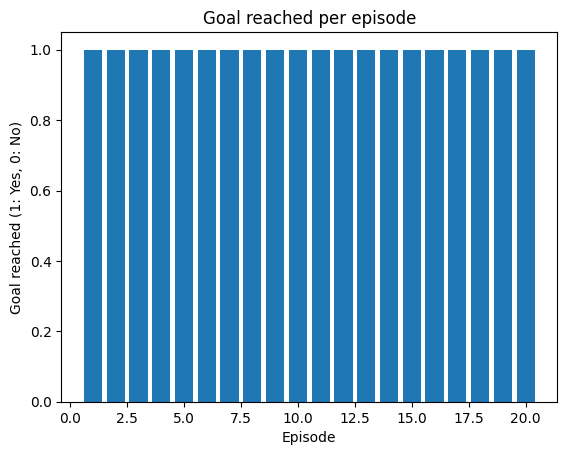

In [21]:
plt.bar(range(1, num_episodes + 1), goal_reached_list)

plt.xlabel('Episode')
plt.ylabel('Goal reached (1: Yes, 0: No)')
plt.title('Goal reached per episode')

plt.show()

=>during the exploitation phase the agent reaches its goal 100% of the time each episode. This shows that SARSA is better than off policy in this environment.